# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
print ("setup done\n")

setup done



## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


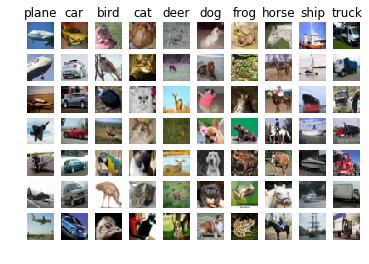

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
print ("done reshaping\n")
# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

done reshaping

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


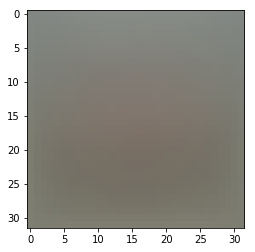

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image
print ("done with subtractions\n")
# why do we do this? => Stack overflow :  serves to "center" the data. Additionally, you ideally would like to 
# divide by the sttdev of that feature or pixel as well if you want to normalize each feature value to a z-score

done with subtractions



In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.111736


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -6.082993 analytic: -6.082993, relative error: 5.451360e-11
numerical: -14.411476 analytic: -14.411476, relative error: 2.029289e-11
numerical: 6.004580 analytic: 6.004580, relative error: 1.467054e-11
numerical: 32.999353 analytic: 32.999353, relative error: 2.152233e-12
numerical: 15.765745 analytic: 15.765745, relative error: 2.137386e-11
numerical: -16.528952 analytic: -16.590635, relative error: 1.862436e-03
numerical: 13.620796 analytic: 13.620796, relative error: 5.650428e-12
numerical: 8.930517 analytic: 8.930517, relative error: 1.616461e-11
numerical: -1.832288 analytic: -1.832288, relative error: 2.885587e-11
numerical: 8.354073 analytic: 8.354073, relative error: 1.373879e-11
numerical: 7.024489 analytic: 7.024489, relative error: 3.145639e-11
numerical: 3.358550 analytic: 3.358550, relative error: 2.447294e-11
numerical: 20.798334 analytic: 20.798334, relative error: 9.277681e-12
numerical: -6.027563 analytic: -6.027563, relative error: 5.163169e-12
numerical: 4

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** The SVM loss function is not strictly speaking differentiable. The point is at the very hinge of the loss function. For [;f(x) = max(-x,0);] at x=0, there is no real gradient. 
**source of help: reddit**

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.111736e+00 computed in 0.142968s
Vectorized loss: 9.111736e+00 computed in 0.065855s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.122224s
Vectorized loss and gradient: computed in 0.008875s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 409.809867
iteration 100 / 1500: loss 243.497321
iteration 200 / 1500: loss 148.842409
iteration 300 / 1500: loss 91.741212
iteration 400 / 1500: loss 57.079103
iteration 500 / 1500: loss 36.245337
iteration 600 / 1500: loss 24.165671
iteration 700 / 1500: loss 15.839547
iteration 800 / 1500: loss 11.512384
iteration 900 / 1500: loss 8.952027
iteration 1000 / 1500: loss 7.585314
iteration 1100 / 1500: loss 6.316617
iteration 1200 / 1500: loss 6.010636
iteration 1300 / 1500: loss 5.223708
iteration 1400 / 1500: loss 5.053512
That took 55.332310s


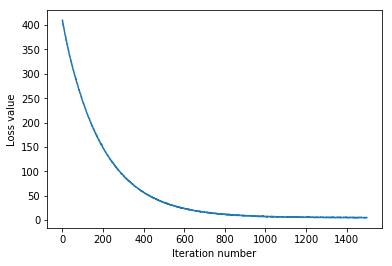

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_lr = None
best_reg = None

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

range_lr = np.linspace(learning_rates[0],learning_rates[1],5)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],5)

print ("strating loop ! This may take a while\n\n")
# loop through all the combinations
for cur_lr in range_lr: #go over the learning rates
    for cur_reg in range_reg:#go over the regularization strength
        # initiate linear classifier with hyperparameters
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=cur_lr, reg=cur_reg,num_iters=1600, verbose=True)
        
        # Training
        y_pred = svm.predict(X_train)
        train_accuracy = np.mean(np.equal(y_train, y_pred, dtype=float))


        # Validation
        y_pred = svm.predict(X_val)  
        val_accuracy = np.mean(np.equal(y_val, y_pred, dtype=float))
  
        results[(cur_lr, cur_reg)] = (train_accuracy, val_accuracy)
  
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
            best_lr = cur_lr
            best_reg = cur_reg

# best results


    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

strating loop ! This may take a while


iteration 0 / 1600: loss 401.836315
iteration 100 / 1600: loss 239.776630
iteration 200 / 1600: loss 145.831922
iteration 300 / 1600: loss 89.607330
iteration 400 / 1600: loss 56.353273
iteration 500 / 1600: loss 36.116630
iteration 600 / 1600: loss 24.513271
iteration 700 / 1600: loss 16.352047
iteration 800 / 1600: loss 11.533623
iteration 900 / 1600: loss 8.731652
iteration 1000 / 1600: loss 7.601978
iteration 1100 / 1600: loss 6.671071
iteration 1200 / 1600: loss 6.382279
iteration 1300 / 1600: loss 5.494139
iteration 1400 / 1600: loss 5.262041
iteration 1500 / 1600: loss 5.637816
iteration 0 / 1600: loss 503.367777
iteration 100 / 1600: loss 263.066988
iteration 200 / 1600: loss 142.368742
iteration 300 / 1600: loss 77.739737
iteration 400 / 1600: loss 43.858984
iteration 500 / 1600: loss 25.262528
iteration 600 / 1600: loss 16.045703
iteration 700 / 1600: loss 10.985047
iteration 800 / 1600: loss 8.169537
iteration 900 / 1600: loss 6.638457

iteration 1100 / 1600: loss 431.631409
iteration 1200 / 1600: loss 373.538761
iteration 1300 / 1600: loss 353.374128
iteration 1400 / 1600: loss 325.531067
iteration 1500 / 1600: loss 310.885105
iteration 0 / 1600: loss 790.376187
iteration 100 / 1600: loss 409.640102
iteration 200 / 1600: loss 490.448874
iteration 300 / 1600: loss 495.202984
iteration 400 / 1600: loss 479.213971
iteration 500 / 1600: loss 565.809302
iteration 600 / 1600: loss 551.557373
iteration 700 / 1600: loss 481.921439
iteration 800 / 1600: loss 445.822005
iteration 900 / 1600: loss 597.311689
iteration 1000 / 1600: loss 565.111693
iteration 1100 / 1600: loss 508.985320
iteration 1200 / 1600: loss 491.311612
iteration 1300 / 1600: loss 582.682967
iteration 1400 / 1600: loss 558.742317
iteration 1500 / 1600: loss 508.775503
iteration 0 / 1600: loss 408.562090
iteration 100 / 1600: loss 450.052184
iteration 200 / 1600: loss 366.310912
iteration 300 / 1600: loss 313.143052
iteration 400 / 1600: loss 349.160451
itera

iteration 0 / 1600: loss 800.284195
iteration 100 / 1600: loss 399623613528847684339137947353382649856.000000
iteration 200 / 1600: loss 66054582762297485612517849043734100144089796219366202771900347317961621504.000000
iteration 300 / 1600: loss 10918293504661079975825903512612116000024570176465301197471611640368587470996815889078078075858503771371864064.000000
iteration 400 / 1600: loss 1804706472568415085146271655271993353093325354558828525808361613010670528504696237100298773696184901466713660839708706450129175342035456848035840.000000
iteration 500 / 1600: loss 298303526163673340793332185982952134410385745396299134013338437119515666164319395014402619294636797923453458409819463108451004977915550769820833560977570878791647856960496893689856.000000
iteration 600 / 1600: loss 4930718378542747720424916752627163983733942441742672587253997178992326521767146344743052767765378879627235378937795993717462823244657653050448293816732585570791105924687525539062714507937649687031168025937714348032

/Users/colby/Documents/CS291 Independent Study/assignment1/cs231n/classifiers/linear_svm.py:99: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(np.square(W))
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/colby/Documents/CS291 Independent Study/assignment1/cs231n/classifiers/linear_svm.py:99: RuntimeWarning: overflow encountered in square
  loss += 0.5 * reg * np.sum(np.square(W))


iteration 900 / 1600: loss inf
iteration 1000 / 1600: loss inf
iteration 1100 / 1600: loss inf
iteration 1200 / 1600: loss inf
iteration 1300 / 1600: loss inf
iteration 1400 / 1600: loss inf
iteration 1500 / 1600: loss inf
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.379449 val accuracy: 0.389000
lr 1.000000e-07 reg 3.125000e+04 train accuracy: 0.375490 val accuracy: 0.369000
lr 1.000000e-07 reg 3.750000e+04 train accuracy: 0.377776 val accuracy: 0.389000
lr 1.000000e-07 reg 4.375000e+04 train accuracy: 0.371000 val accuracy: 0.375000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.373306 val accuracy: 0.376000
lr 1.257500e-05 reg 2.500000e+04 train accuracy: 0.204755 val accuracy: 0.221000
lr 1.257500e-05 reg 3.125000e+04 train accuracy: 0.181735 val accuracy: 0.182000
lr 1.257500e-05 reg 3.750000e+04 train accuracy: 0.198102 val accuracy: 0.185000
lr 1.257500e-05 reg 4.375000e+04 train accuracy: 0.190082 val accuracy: 0.202000
lr 1.257500e-05 reg 5.000000e+04 train accuracy:

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.080163
validation accuracy: 0.092000


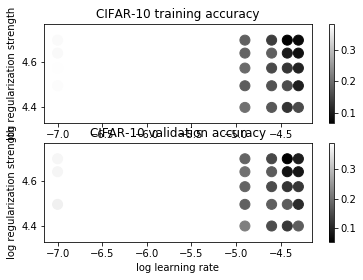

In [19]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [20]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.379000


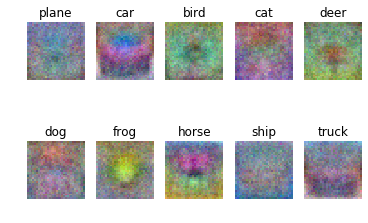

In [21]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** The multiclass SVM templates resemble similar characteristics to how these object classes look like. The car template is mostly red, which shows a bias in the car dataset, whilst the horse SVM weights show  a horse possibly facing both sides. The ship and plane both have dominant blue, for sky or ocean water. These trained weights for the SVM classes overall gave me a more intuitive understanding of SGD and linear classification&optimisation, as these optiomal template from the random ones assigned indicate pattern recognition from the CIFAR 10 image data. The pixel weights are the features that lead to the best prediction scores and viewing these as a human, these templates closely resemble how objects in these classes look, tho unclear for objects like animals (dog, dear and frog), although general shape outline is very clear. This would not be very easy to distinguish for a multiple animals dataset, with just this method.  